# Text Cleaning

In [1]:
import nltk, re
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
 
def spell_correct(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\0s", "0", text)    
    return text
 
def remove_url(text):
    URL_REGEX = re.compile(r'''((http[s]?://)[^ <>'"{}|\\^`[\]]*)''')
    return URL_REGEX.sub(r' ', text)
 
remove_punc = lambda x : re.sub(r"\W", ' ', x)
 
remove_num = lambda x : re.sub(r"\d", ' ', x)
 
remove_extra_spaces = lambda x : re.sub(r"\s+", ' ', x)
 
lower_case = lambda x : x.lower()
 
with open('stopwords.txt') as f:
    sw = map(lambda x : x.strip(), f.readlines())
stop_words = set(nltk.corpus.stopwords.words('english'))|set(sw)
remove_stopwords = lambda x: ' '.join(word for word in x.split() if word not in stop_words)
 
ps = PorterStemmer()
ps_stem = lambda x: ' '.join(ps.stem(word) for word in x.split())
 
wnl = WordNetLemmatizer()
wnl_lemmatize = lambda x: ' '.join(wnl.lemmatize(word) for word in x.split())
 
def tag_pos(x):
    tag_list =  nltk.pos_tag(nltk.word_tokenize(x))
    pos = ""
    for t in tag_list:
        pos += t[0] +'(' + t[1] +')' + ' '
    return pos
 
def cleanText(x, rsw, stm, lem, tgps):
    x = str(x)
    x = remove_url(x)
    x = lower_case(x)
    x = spell_correct(x)
    x = remove_punc(x)
    x = remove_num(x)
    x = remove_extra_spaces(x)
   
    if rsw:
        x = remove_stopwords(x)
    if stm:
        x = ps_stem(x)
    if lem:
        x = wnl_lemmatize(x)
    if tgps:
        x = tag_pos(x)
    return x

# Various Similarity Metrics

## Jaccard Similarity:
Jaccard similarity or intersection over union is defined as size of intersection divided by size of union of two sets.

In [2]:
def jaccard_sim(str1, str2):
    a = set(cleanText(str1, True, False, True, False).split())
    b = set(cleanText(str2, True, False, True, False).split())
    c = a & b
    d = a | b
    return float(len(c)) / (len(d))*100

In [3]:
jaccard_sim('AI is our friend and it has been friendly', 'AI and humans have always been friendly')

40.0

## Cosine Similarity:
Cosine similarity calculates similarity by measuring the cosine of angle between two vectors.

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
 
def cosine_sim(str1, str2):
    str_ = [cleanText(str1, True, False, True, False), cleanText(str2, True, False, True, False)]
    vectorizer = CountVectorizer()
    vect_ = vectorizer.fit_transform(str_).toarray()
    return cosine_similarity([vect_[0]], [vect_[1]])[0][0]*100
 

In [5]:
cosine_sim('AI is our friend and it has been friendly', 'AI and humans have always been friendly')

57.73502691896258

## Fuzzy String Matching
Fuzzy string matching is the technique of finding strings that match a pattern approximately (rather than exactly). In another word, fuzzy string matching is a type of search that will find matches even when users misspell words or enter only partial words for the search. It is also known as approximate string matching.

In [6]:
from fuzzywuzzy import fuzz

D:\Users\Ritvik\Anaconda3\envs\datascience\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### Ratio
ratio compares the entire string similarity, in order

In [7]:
def fuzz_ratio(str1, str2):
    return fuzz.ratio(cleanText(str1, True, False, True, False),
                      cleanText(str2, True, False, True, False))

In [8]:
fuzz_ratio('AI is our friend and it has been friendly', 'AI and humans have always been friendly')

62

### Partial Ratio
partial_ratio compares partial string similarity

In [9]:
def fuzz_partial_ratio(str1, str2):
    return fuzz.partial_ratio(cleanText(str1, True, False, True, False),
                              cleanText(str2, True, False, True, False))

In [10]:
fuzz_partial_ratio('AI is our friend and it has been friendly', 'AI and humans have always been friendly')

61

### Token Sort Ratio
token_sort_ratio ignores word order

In [11]:
def fuzz_token_sort_ratio(str1, str2):
    return fuzz.token_sort_ratio(cleanText(str1, True, False, True, False),
                              cleanText(str2, True, False, True, False))

In [12]:
fuzz_token_sort_ratio('AI is our friend and it has been friendly', 'AI and humans have always been friendly')

57

### Token Set Ratio
token_set_ratio ignores duplicated words

In [13]:
def fuzz_token_set_ratio(str1, str2):
    return fuzz.token_sort_ratio(cleanText(str1, True, False, True, False),
                              cleanText(str2, True, False, True, False))

In [14]:
fuzz_token_set_ratio('AI is our friend and it has been friendly', 'AI and humans have always been friendly')

57

## Removing and Matching Synonyms

In [15]:
from nltk.corpus import wordnet
 
def compute_synonyms(x):
    synonyms_list = [x]
    for syn in wordnet.synsets(x):
        for s in syn.lemmas():
            synonyms_list.append(s.name())
    return set(synonyms_list)
 
def remove_synonyms(str_):
    words = cleanText(str_, True, False, True, False).split()
    synonyms = set()
    reduced_words = set()
    for w in words:
        flag = 0
        syns = compute_synonyms(w)
        for s in syns:
            if s in synonyms:
                flag = 1
                break
        synonyms = synonyms | syns
        if flag == 0:
            reduced_words = reduced_words|set([w])
    return reduced_words

### Jaccard Similarity

In [16]:
def jaccard_sim_syn(str1, str2):
    a = remove_synonyms(str1)
    b = remove_synonyms(str2)
    c = 0
    for w in a:
        syns = compute_synonyms(w)
        for s in syns:
            if s in b:
                c += 1
    return float(c / (len(a)+len(b)-c))*100

In [17]:
jaccard_sim_syn('AI is our friend and it has been friendly', 'AI and humans have always been friendly')

40.0

# Testing

In [18]:
from sklearn.metrics import confusion_matrix, classification_report

In [19]:
import pandas as pd
 
pd.options.display.max_columns = 10
pd.options.display.max_colwidth = -1

In [20]:
df = pd.read_csv('Quora Question Pairs.csv')

In [21]:
d0 = df[df['is_duplicate'] == 0].sample(n=25)
d1 = df[df['is_duplicate'] == 1].sample(n=25)
d = pd.concat([d0, d1], axis=0)
d = d.sample(n=50)
d = d.reset_index(drop=True)

In [22]:
d['Jaccard'] = d[['question1', 'question2']].apply(lambda x: jaccard_sim(x.question1, x.question2), axis=1)
d['Cosine'] = d[['question1', 'question2']].apply(lambda x: cosine_sim(x.question1, x.question2), axis=1)
d['F Ratio'] = d[['question1', 'question2']].apply(lambda x: fuzz_ratio(x.question1, x.question2), axis=1)
d['F Partial Ratio'] = d[['question1', 'question2']].apply(lambda x: fuzz_partial_ratio(x.question1, x.question2), axis=1)
d['F Token Sort Ratio'] = d[['question1', 'question2']].apply(lambda x: fuzz_token_sort_ratio(x.question1, x.question2), axis=1)
d['F Token Set Ratio'] = d[['question1', 'question2']].apply(lambda x: fuzz_token_set_ratio(x.question1, x.question2), axis=1)
d['S Jaccard'] = d[['question1', 'question2']].apply(lambda x: jaccard_sim_syn(x.question1, x.question2), axis=1)

In [23]:
d

,question1,question2,is_duplicate,Jaccard,Cosine,F Ratio,F Partial Ratio,F Token Sort Ratio,F Token Set Ratio,S Jaccard
0,What are the best books in Telugu literature?,What are the best Telugu books?,1,75.000000,86.602540,56,69,74,74,75.000000
1,Why was north west province given to pakistan?,What is the difference between north of west and west of north?,0,33.333333,59.628479,45,44,48,48,33.333333
2,What is it like getting tortured?,What is it like being tortured?,1,66.666667,81.649658,76,77,76,76,66.666667
3,Is it normal to only have periods every 2-3 months?,Why do I get my period every 3 months? Is it normal?,1,80.000000,89.442719,70,76,93,93,80.000000
4,"If a recipe calls for a Dutch oven, what can I substitute instead?",What can you substitute for milk in cooking?,0,12.500000,23.570226,41,63,50,50,12.500000
5,What colors look best on olive skin?,What is the best foundation for olive skin?,0,50.000000,67.082039,58,58,69,69,50.000000
6,How do you do the keyword research?,How do you do your keyword research?,1,100.000000,100.000000,100,100,100,100,100.000000
7,What are the safety precautions on handling shotguns proposed by the NRA in Alaska?,What are the safety precautions on handling firearms proposed by the NRA in the entire U.S. including it’s territories and possessions?,1,38.461538,59.761430,61,76,62,62,27.272727
8,Which is harder between giving up smoking and masturbating?,"I want to stop smoking, but it is so hard. Can you give some advices?",0,11.111111,20.412415,44,44,47,47,28.571429
9,"Can my parents take away my iPhone, Even though I bought it myself and pay my own bill?","If a 17 year old bought an iPhone with their own money, do parents still have the right to take their phone away if they misbehave?",1,31.250000,48.112522,42,45,53,53,42.857143


In [24]:
def report(col):
    print(confusion_matrix(d['is_duplicate'], list(map(lambda x :round(x/100), d[col]))))
    print(classification_report(d['is_duplicate'], list(map(lambda x :round(x/100), d[col]))))

In [25]:
algos = d.columns.drop(['question1', 'question2', 'is_duplicate'])
for a in algos:
    print(a)
    report(a)

Jaccard
[[22  3]
 [ 9 16]]
              precision    recall  f1-score   support

           0       0.71      0.88      0.79        25
           1       0.84      0.64      0.73        25

   micro avg       0.76      0.76      0.76        50
   macro avg       0.78      0.76      0.76        50
weighted avg       0.78      0.76      0.76        50

Cosine
[[14 11]
 [ 4 21]]
              precision    recall  f1-score   support

           0       0.78      0.56      0.65        25
           1       0.66      0.84      0.74        25

   micro avg       0.70      0.70      0.70        50
   macro avg       0.72      0.70      0.69        50
weighted avg       0.72      0.70      0.69        50

F Ratio
[[14 11]
 [ 2 23]]
              precision    recall  f1-score   support

           0       0.88      0.56      0.68        25
           1       0.68      0.92      0.78        25

   micro avg       0.74      0.74      0.74        50
   macro avg       0.78      0.74      0.73     

In [26]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

<IPython.core.display.Javascript object>


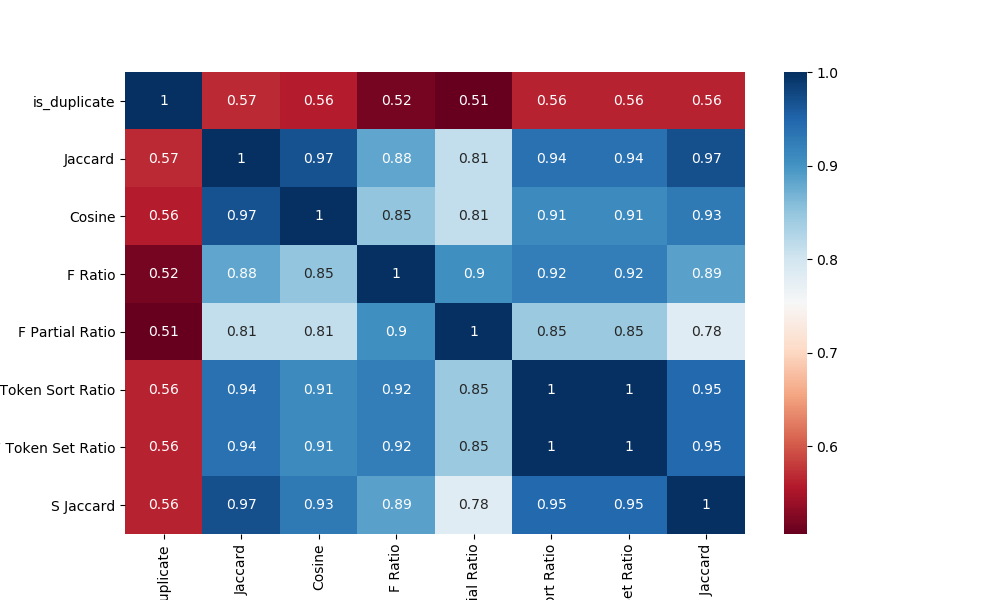

In [27]:
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(d.drop(['question1', 'question2'], axis=1).corr(), ax=ax, annot=True, cmap='RdBu')